In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
import faiss                   # make faiss available
import umap
import seaborn as sns
%matplotlib inline
from byol_pytorch import BYOL

import os
import sys
import matplotlib.pyplot as plt
from sklearn import svm
sys.path.append('..')

import torchvision.models as models
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from pl_bolts.models.self_supervised import SimCLR
import lightgbm as lgb

from src.beam import UniversalDataset, Experiment, Algorithm, beam_arguments, PackedFolds

2022-07-25 14:31:29.609910: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class STL10Dataset(UniversalDataset):

    def __init__(self, hparams, subset='unlabeled'):

        path = hparams.path_to_data
        seed = hparams.split_dataset_seed

        super().__init__()
        
        self.normalize = True
        
        if subset == 'unlabeled':
            
            x = torch.tensor(np.fromfile(os.path.join(path, 'unlabeled_X.bin'), dtype=np.uint8))
            self.data = torch.reshape(x, (-1, 3, 96, 96)).permute(0, 1, 3, 2)
            self.labels = torch.LongTensor(len(self.data)).zero_()
            self.split(test=.2, seed=seed)
            
        else:
            
            x_train = torch.tensor(np.fromfile(os.path.join(path, 'train_X.bin'), dtype=np.uint8)).reshape((-1, 3, 96, 96)).permute(0, 1, 3, 2)
            x_test = torch.tensor(np.fromfile(os.path.join(path, 'test_X.bin'), dtype=np.uint8)).reshape((-1, 3, 96, 96)).permute(0, 1, 3, 2)
            y_train = torch.tensor(np.fromfile(os.path.join(path, 'train_y.bin'), dtype=np.uint8))
            y_test = torch.tensor(np.fromfile(os.path.join(path, 'test_y.bin'), dtype=np.uint8))
            
            self.data = PackedFolds({'train': x_train, 'test': x_test})
            self.labels = PackedFolds({'train': y_train, 'test': y_test})
            self.split(test=self.labels['test'].index, seed=seed)
            
        self.transform = torchvision.transforms.Resize((224, 224))
    
    def getitem(self, index):
        
        x = self.data[index]
        
        if self.normalize:
#             mu = self.mu
#             std = self.std
            
#             if len(x.shape) == 3:
#                 mu = mu.squeeze(0)
#                 std = std.squeeze(0)
                
#             x = (x.float() - mu) / std
            x = x.float() / 255
            

            
        x = self.transform(x)
            
        return {'x': x, 'y': self.labels[index]}

In [3]:
path_to_data = '/home/shared/data/dataset/stl10/stl10_binary'
root_dir = '/home/shared/data/results'

hparams = beam_arguments(
    f"--project-name=similarity --root-dir={root_dir} --algorithm=STL10 --identifier=dev  --device=0",
    "--epoch-length-train=50 --epoch-length-eval=20 --no-scale-epoch-by-batch-size --batch-size=128 --no-override",
    path_to_data=path_to_data)

In [4]:
dataset_unlabeled = STL10Dataset(hparams, subset='unlabeled')
dataset_labeled = STL10Dataset(hparams, subset='labeled')

In [53]:
class BeamCLR(Algorithm):

    def __init__(self, hparams):

        # choose your network
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)
        encoder = simclr.encoder
        
        super().__init__(hparams, networks=encoder)

    
    def preprocess_inference(self, results=None, **kwargs):
        self.dataset.normalize = True
        return results
    
    def inference(self, sample=None, results=None, subset=None, predicting=True, **kwargs):

        if predicting:
            x = sample
        else:
            x, y = sample['x'], sample['y']

        net = self.networks['net']
        z = net(x)[0]

        if not predicting:
            return {'z': z, 'y': y}, results

        return z, results
    
    
def show_image(i):
    
    dataset_labeled.normalize = False
    im = np.array(dataset_labeled[i][1]['x'].permute(1, 2, 0))
    plt.imshow(im)
    plt.show()
    dataset_labeled.normalize = True

In [6]:
experiment = Experiment(hparams, print_hyperparameters=False)

2022-07-25 14:31:40 | INFO | Creating new experiment
2022-07-25 14:31:40 | INFO | Experiment directory is: /home/shared/data/results/similarity/STL10/dev/0001_20220725_143140


In [7]:
alg = experiment.algorithm_generator(BeamCLR, dataset_unlabeled)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:217: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['non_linear_evaluator.block_forward.2.weight', 'non_linear_evaluator.block_forward.2.bias']
  rank_zero_warn(


In [8]:
features_train = alg.evaluate(dataset_labeled)

evaluate:   1%|          | 1/102 [00:00<?, ?it/s]

In [9]:
z = features_train.values['z'].detach().cpu().numpy()
y = features_train.values['y'].detach().cpu().numpy()

In [10]:
index_train = np.array(dataset_labeled.indices_split['train'])
index_test = np.array(dataset_labeled.indices_split['test'])

## LightBGM

In [11]:
train_data = lgb.Dataset(z[index_train], label=y[index_train]-1)

In [14]:
validation_data = lgb.Dataset(z[index_test], label=y[index_test]-1)

In [26]:
num_round = 20
param = {'objective': 'multiclass', 
         'num_leaves': 31, 
         'max_depth': 4,
         'gpu_device_id': 1,
         'verbosity':-1,
         'metric': ['multi_error', 'multiclass'],
         'num_class': 10}
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

[1]	valid_0's multi_error: 0.071375	valid_0's multi_logloss: 1.58561
[2]	valid_0's multi_error: 0.05775	valid_0's multi_logloss: 1.25965
[3]	valid_0's multi_error: 0.051625	valid_0's multi_logloss: 1.03836
[4]	valid_0's multi_error: 0.048375	valid_0's multi_logloss: 0.872124
[5]	valid_0's multi_error: 0.04225	valid_0's multi_logloss: 0.740766
[6]	valid_0's multi_error: 0.04025	valid_0's multi_logloss: 0.636226
[7]	valid_0's multi_error: 0.037	valid_0's multi_logloss: 0.549614
[8]	valid_0's multi_error: 0.03475	valid_0's multi_logloss: 0.477192
[9]	valid_0's multi_error: 0.033	valid_0's multi_logloss: 0.416818
[10]	valid_0's multi_error: 0.032	valid_0's multi_logloss: 0.365659
[11]	valid_0's multi_error: 0.0295	valid_0's multi_logloss: 0.321969
[12]	valid_0's multi_error: 0.027375	valid_0's multi_logloss: 0.284315
[13]	valid_0's multi_error: 0.025	valid_0's multi_logloss: 0.252128
[14]	valid_0's multi_error: 0.02325	valid_0's multi_logloss: 0.224574
[15]	valid_0's multi_error: 0.02175	v

## Faiss

In [56]:
d = z.shape[-1]

res = faiss.StandardGpuResources()

# build a flat (CPU) index
index_flat = faiss.IndexFlatL2(d)
# make it into a gpu index
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)

gpu_index_flat.add(z)         # add vectors to the index
print(gpu_index_flat.ntotal)

i = 9001

D, I = gpu_index_flat.search(z[[i]], 1000) # sanity check

print(len(np.unique(y[I[0]])))

zvi = z[I[0]]

reducer = umap.UMAP()

embedding = reducer.fit_transform(zvi)

13000
7


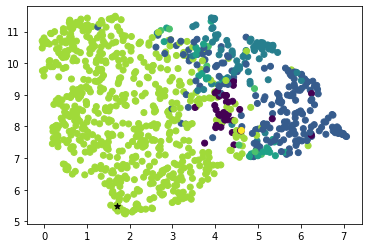

In [57]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=y[I[0]])
plt.scatter(
    embedding[:1, 0],
    embedding[:1, 1],
    c='black', marker='*')
plt.show()

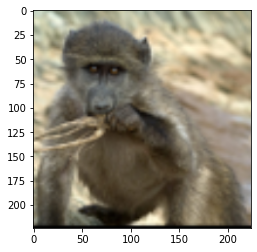

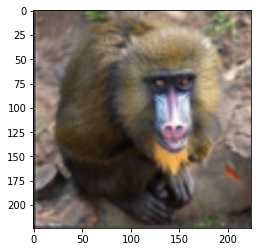

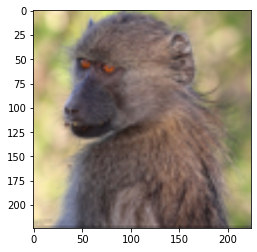

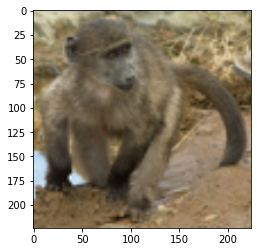

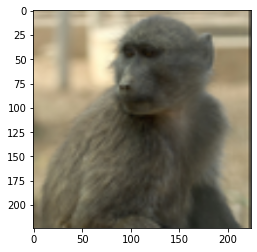

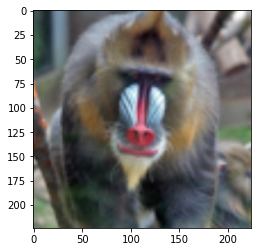

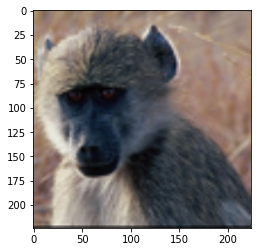

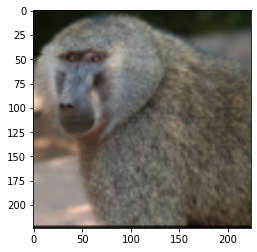

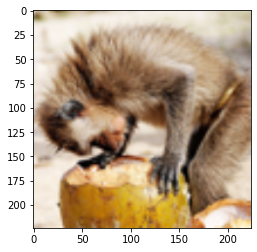

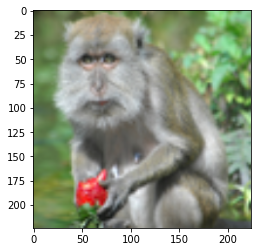

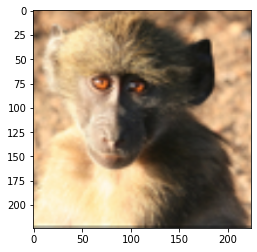

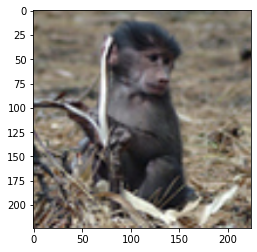

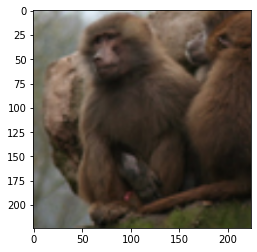

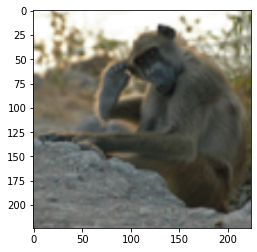

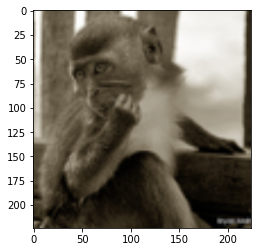

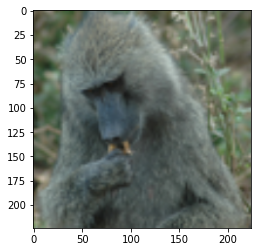

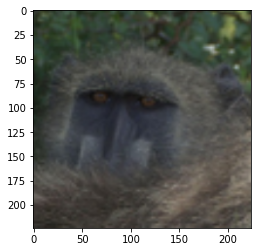

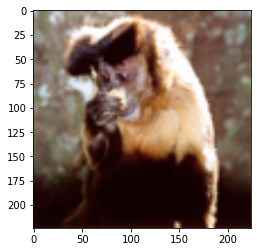

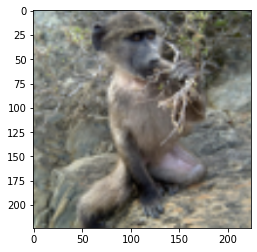

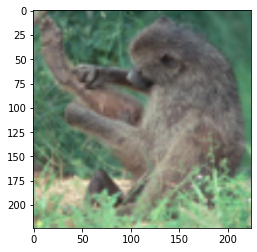

In [58]:
for ii in I[0][:20]:
    show_image(ii)